<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If torchdiffeq isn't installed, run this once:
!pip -q install torchdiffeq

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdiffeq import odeint_adjoint as odeint  # continuous adjoint
# from torchdiffeq import odeint  # alternative

plt.rcParams["figure.dpi"] = 120


In [2]:
path_test = '/content/drive/MyDrive/Physics Informed ML/HW/HW5/DailyDelhiClimateTest.csv'
path_train = '/content/drive/MyDrive/Physics Informed ML/HW/HW5/DailyDelhiClimateTrain.csv'

torch.manual_seed(1)
np.random.seed(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

features = ["meantemp", "humidity", "wind_speed", "meanpressure"]

df_month = (
    df.groupby(["year", "month"], as_index=False)[features]
      .mean()
      .sort_values(["year", "month"])
      .reset_index(drop=True)
)

In [5]:
df_month["date_float"] = df_month["year"] + df_month["month"] / 12.0
t = df_month["date_float"].to_numpy()
t = t - t.min()

Y = df_month[features].to_numpy()  # shape (T, 4)

df_month.head()

,year,month,meantemp,humidity,wind_speed,meanpressure,date_float
0,2013,1,12.074770,73.028802,4.833913,1017.847734,2013.083333
1,2013,2,16.867560,71.938563,7.474090,1015.946003,2013.166667
2,2013,3,22.814209,57.417243,8.757270,1011.733909,2013.250000
3,2013,4,28.895119,34.612103,8.046385,1006.292341,2013.333333
4,2013,5,33.776767,28.938249,8.943452,999.924194,2013.416667


In [6]:
Y_mean = Y.mean(axis=0, keepdims=True)
Y_std = Y.std(axis=0, keepdims=True) + 1e-8 # para no dividir para 0
Yz = (Y- Y_mean)/Y_std

t_torch = torch.tensor(t, dtype=torch.float32, device=device) # (T,)
Y_torch = torch.tensor(Yz, dtype=torch.float32, device=device) # (T,D)

T_train = 20

t_train = t_torch[:T_train]
y_train = Y_torch[:T_train]

t_test = t_torch[T_train-1:]
y_test = Y_torch[T_train-1:]

len(t_train), len(t_test), y_train.shape

(20, 33, torch.Size([20, 4]))

In [7]:
def make_activation(name: str):
    name = name.lower()
    if name == "tanh": return nn.Tanh()
    if name == "relu": return nn.ReLU()
    if name == "gelu": return nn.GELU()
    if name in ("silu", "swish"): return nn.SiLU()
    if name == "elu": return nn.ELU()
    if name == "softplus": return nn.Softplus()
    raise ValueError(f"Unknown activation: {name}")

In [8]:
class ODEFunc(nn.Module):
  def __init__(self, dim, hidden1=64, hidden2=32, act="silu"):
    super().__init__()
    a = make_activation(act)
    self.net = nn.Sequential(
        nn.Linear(dim, hidden1), a,
        nn.Linear(hidden1, hidden2), a,
        nn.Linear(hidden2, dim),
    )
    for m in  self.net.modules():
        if isinstance(m,nn.Linear):
          nn.init.normal_(m.weight, mean=0.0, std=0.05)
          nn.init.constant_(m.bias, 0.0)

  def forward(self, t, y):
      return self.net(y)


def rollout(func, y0, tspan, rtol=1e-6, atol=1e-6, method='dopri5'):
    return odeint(func, y0, tspan, rtol=rtol, atol=atol, method=method)

In [9]:
def train_incremental(
    act='silu',
    lr=1e-2,
    iters_per_stage=400,
    stage_step=4,
    method="dopri5",
    rtol=1e-6,
    atol=1e-6,

):

  dim = y_train.shape[1]
  func = ODEFunc(dim, act=act).to(device)

  opt = torch.optim.AdamW(func.parameters(), lr=lr)
  loss_fn = nn.MSELoss()

  stage_size = list(range(stage_step, len(t_train)+1, stage_step))
  if stage_size[-1] != len(t_train):
      stage_size.append(len(t_train))

  hist = []
  for k in stage_size:
      t_k = t_train[:k]
      y_k = y_train[:k]
      y0 = y_k[0]

      for it in range(iters_per_stage):

          opt.zero_grad()
          pred= rollout(func, y0, t_k, rtol=rtol, atol=atol, method=method)
          loss = loss_fn(pred, y_k)
          loss.backward()
          opt.step()

          if (it+1) % max(1, iters_per_stage //5)==0:
              hist.append((k, it+1, float(loss.detach().cpu())))

      with torch.no_grad():
          pred_k = rollout(func, y0, t_k, rtol=rtol, atol=atol, method=method).detach().cpu().numpy()
          true_k = y_k.detach().cpu().numpy()
          t_plot = t_k.detach().cpu().numpy()

      fig, axes = plt.subplots(dim,1, figsize=(10,2.2*dim), sharex=True)
      if dim ==1: axes = [axes]
      for i, ax in enumerate(axes):
          ax.plot(t_plot, true_k[:,1], label="train true")
          ax.plot(t_plot, pred_k[:,1], label="train prediction")
          ax.set_ylabel(features[i])
          ax.legend()
      axes[-1].set_xlabel("time (shifted years)")
      fig.suptitle(f"Stage k={k} | act={act} | lr={lr} | iters={iters_per_stage}")
      plt.tight_layout()
      plt.show()

  return func, hist

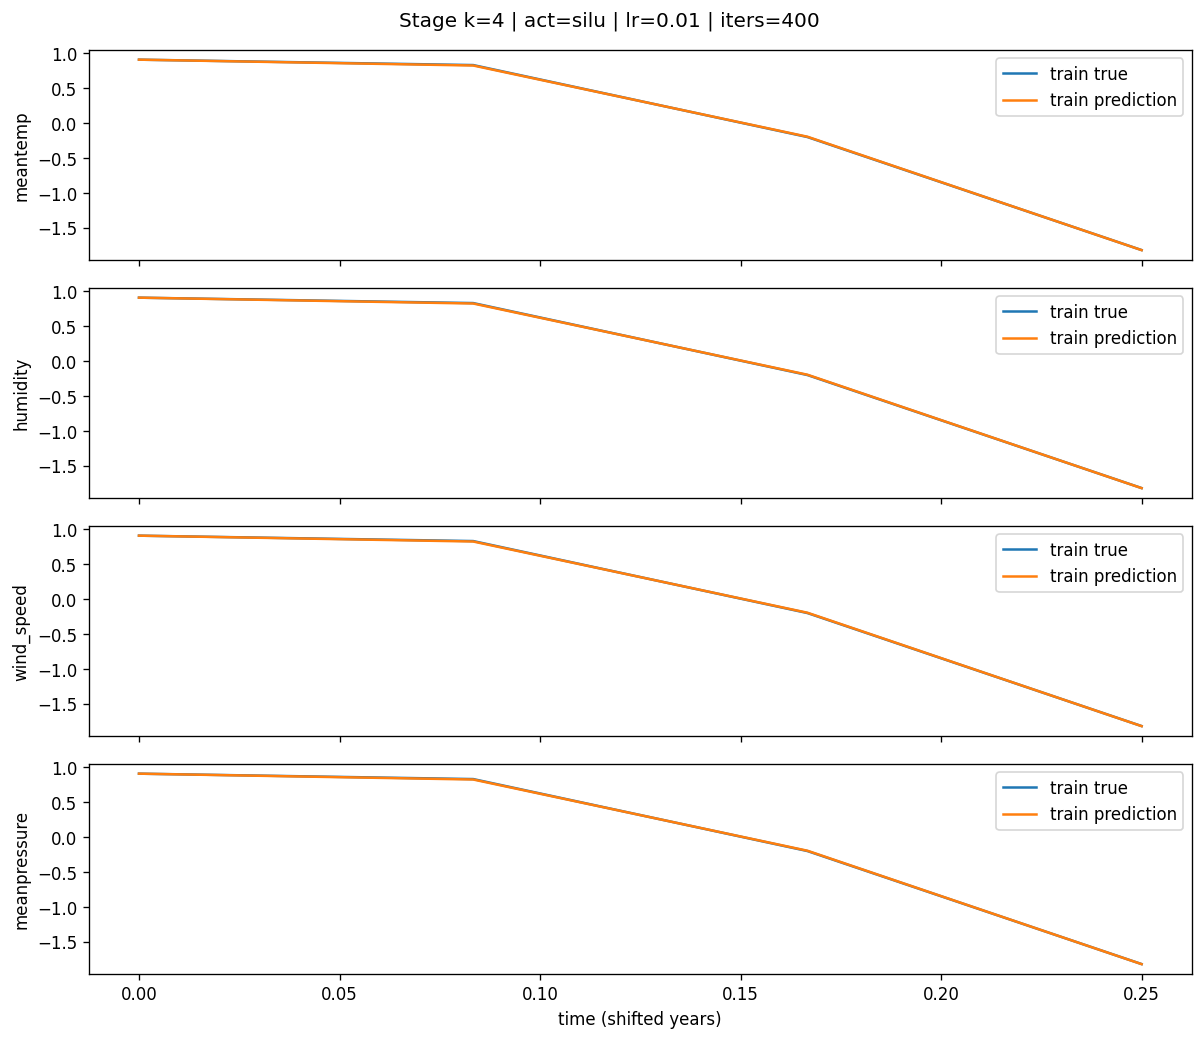

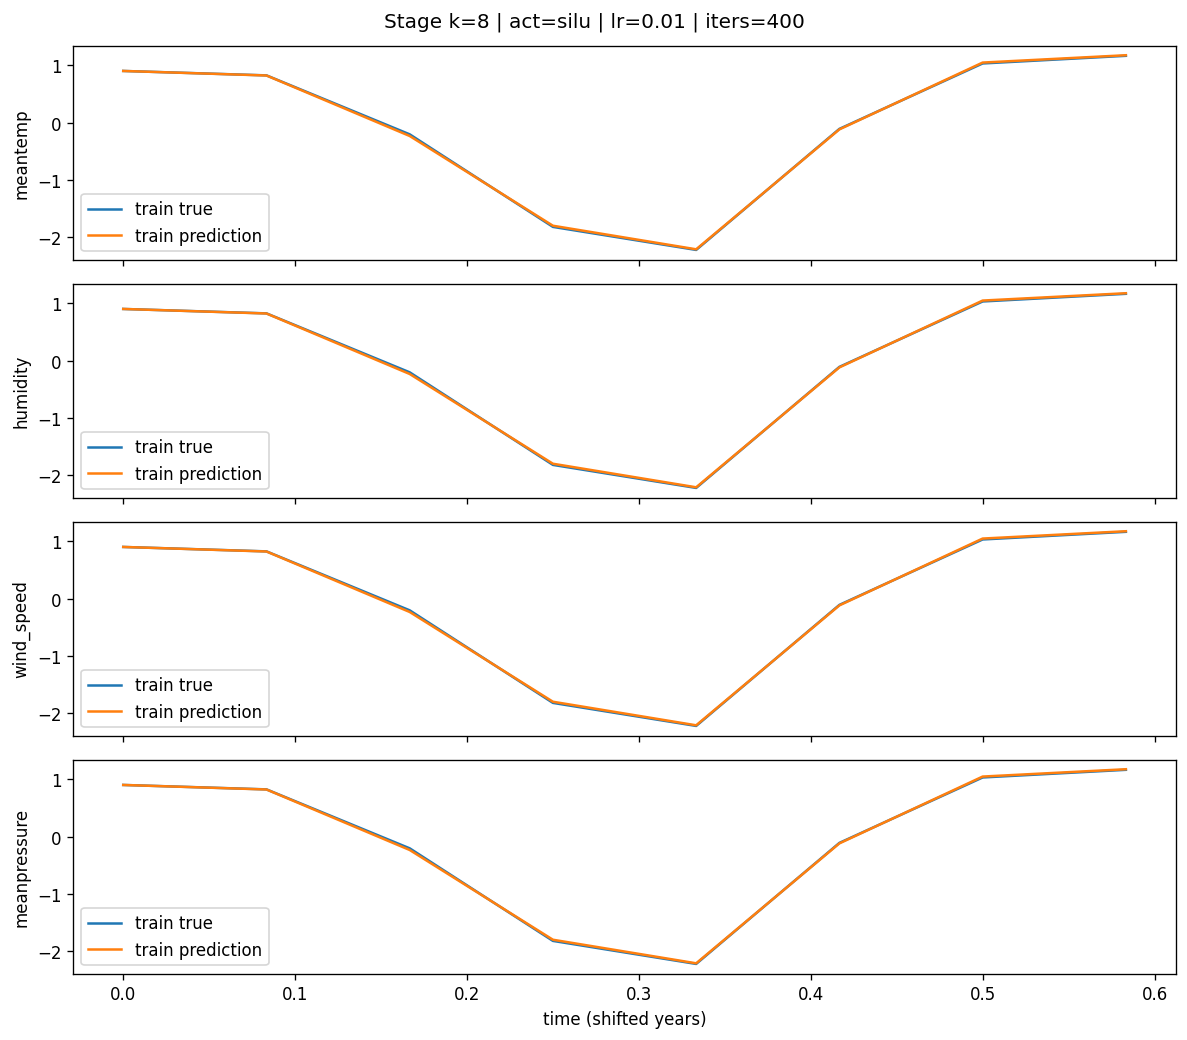

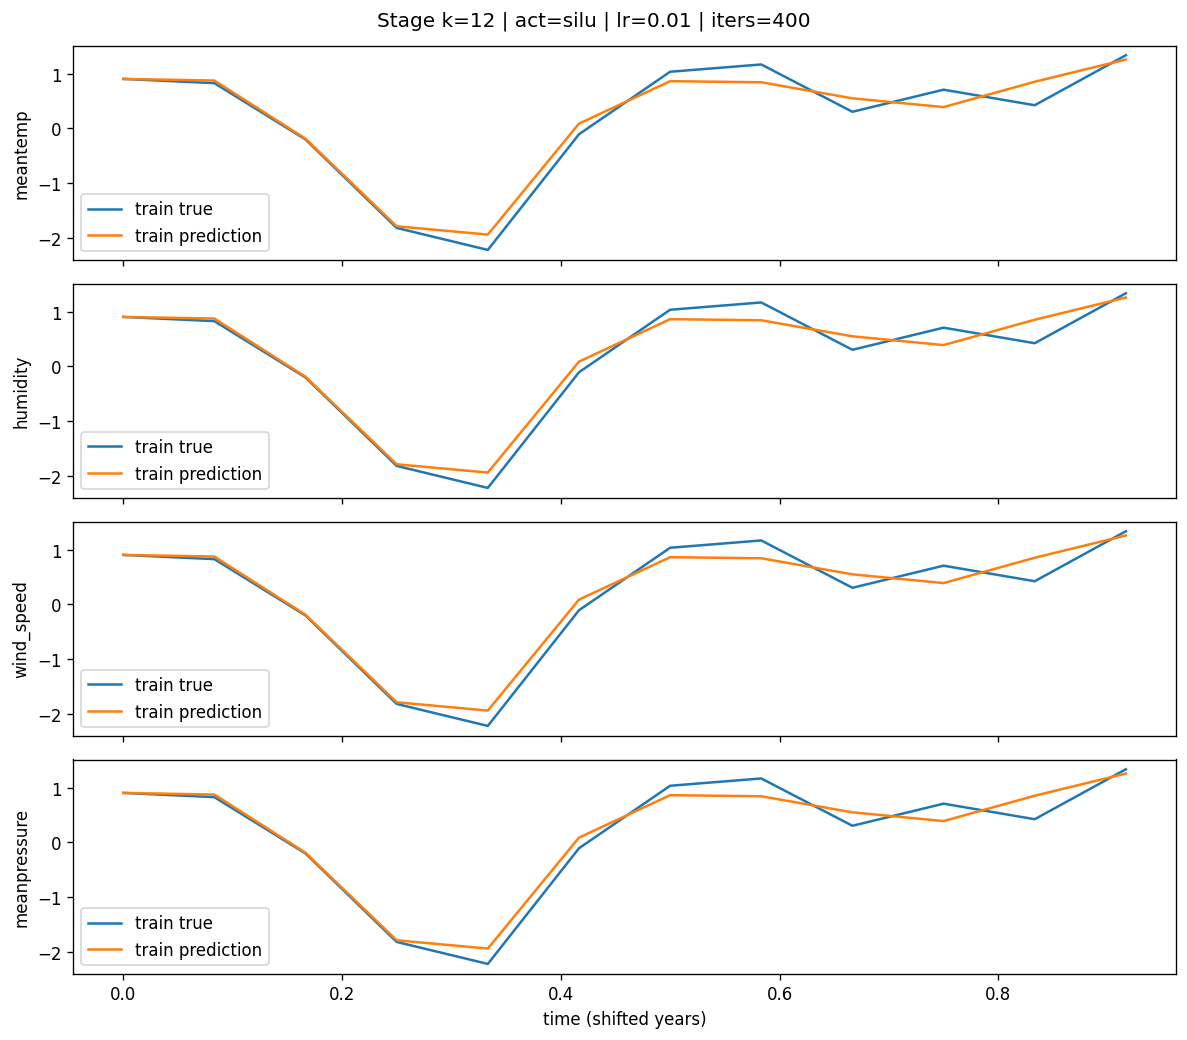

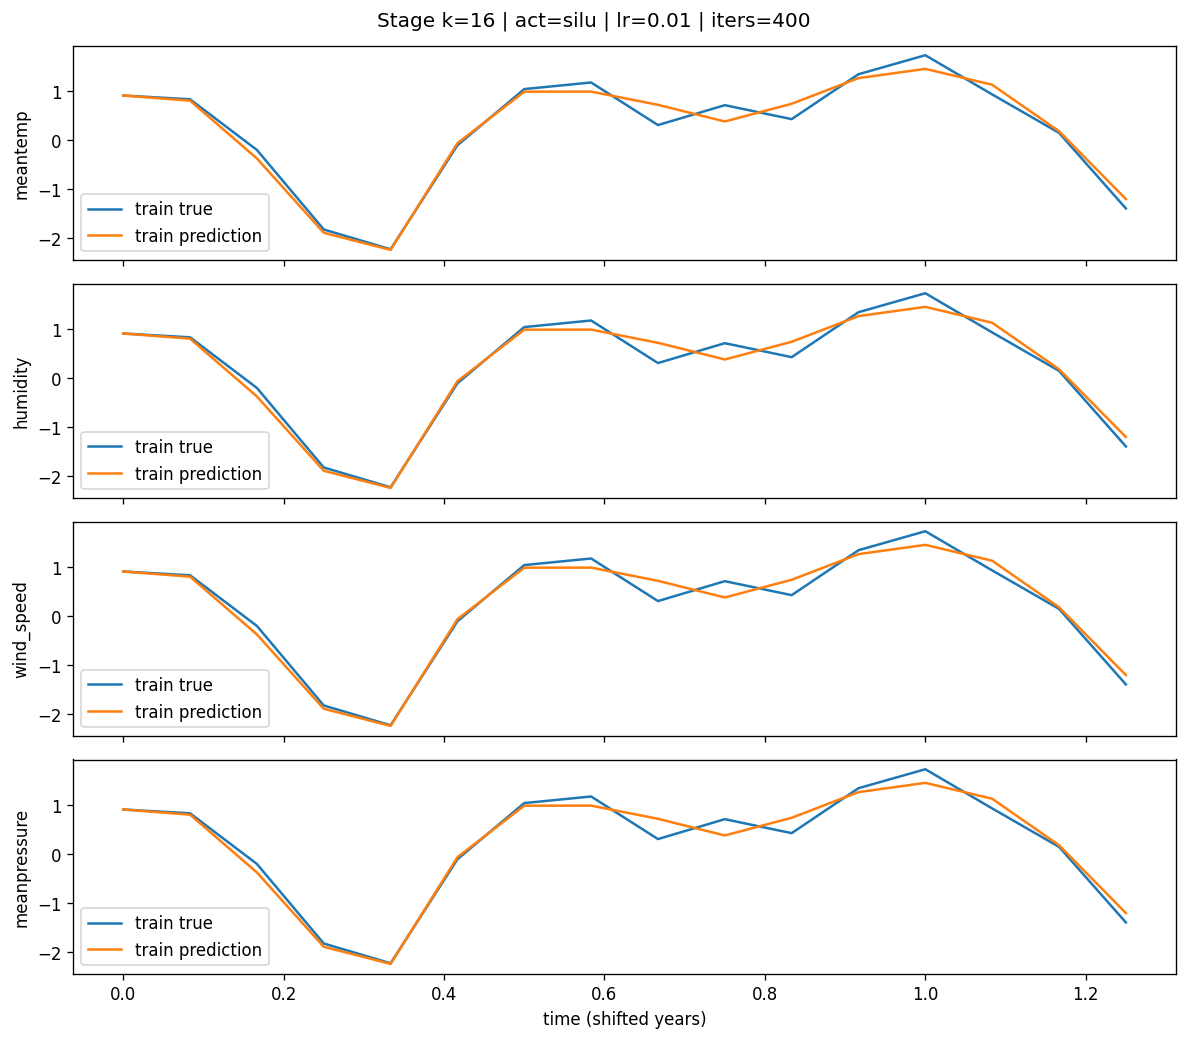

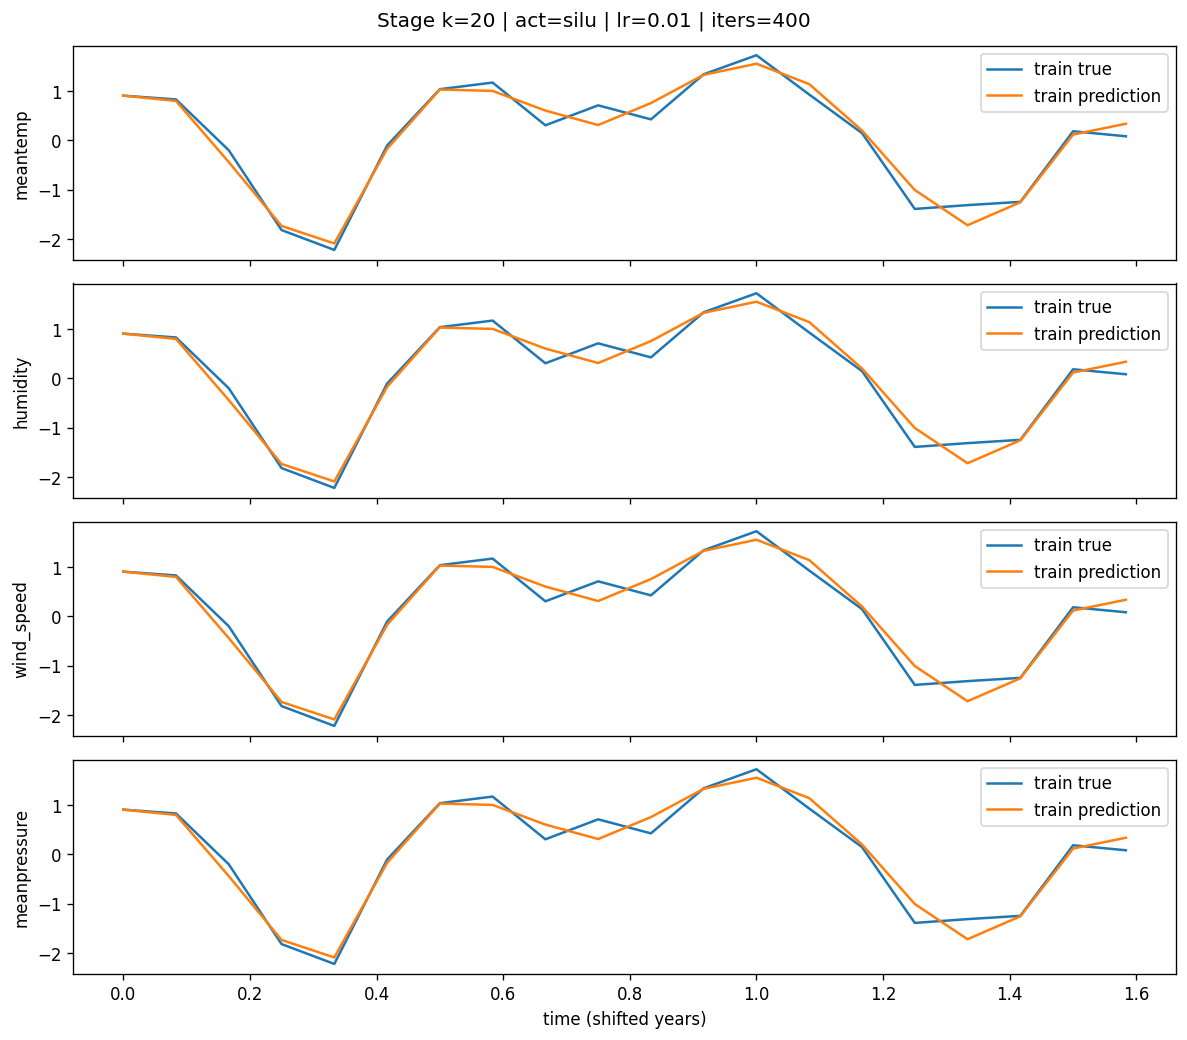

[(16, 80, 0.05595911666750908),
 (16, 160, 0.048401497304439545),
 (16, 240, 0.04301615059375763),
 (16, 320, 0.054333314299583435),
 (16, 400, 0.036433134227991104),
 (20, 80, 0.04678451269865036),
 (20, 160, 0.05487382039427757),
 (20, 240, 0.039330363273620605),
 (20, 320, 0.038030918687582016),
 (20, 400, 0.035227227956056595)]

In [10]:
func, hist = train_incremental(
    act="silu",
    lr=1e-2,
    iters_per_stage=400,
    stage_step=4,
    method="dopri5",
    rtol=1e-6,
    atol=1e-6,
)

hist[-10:]

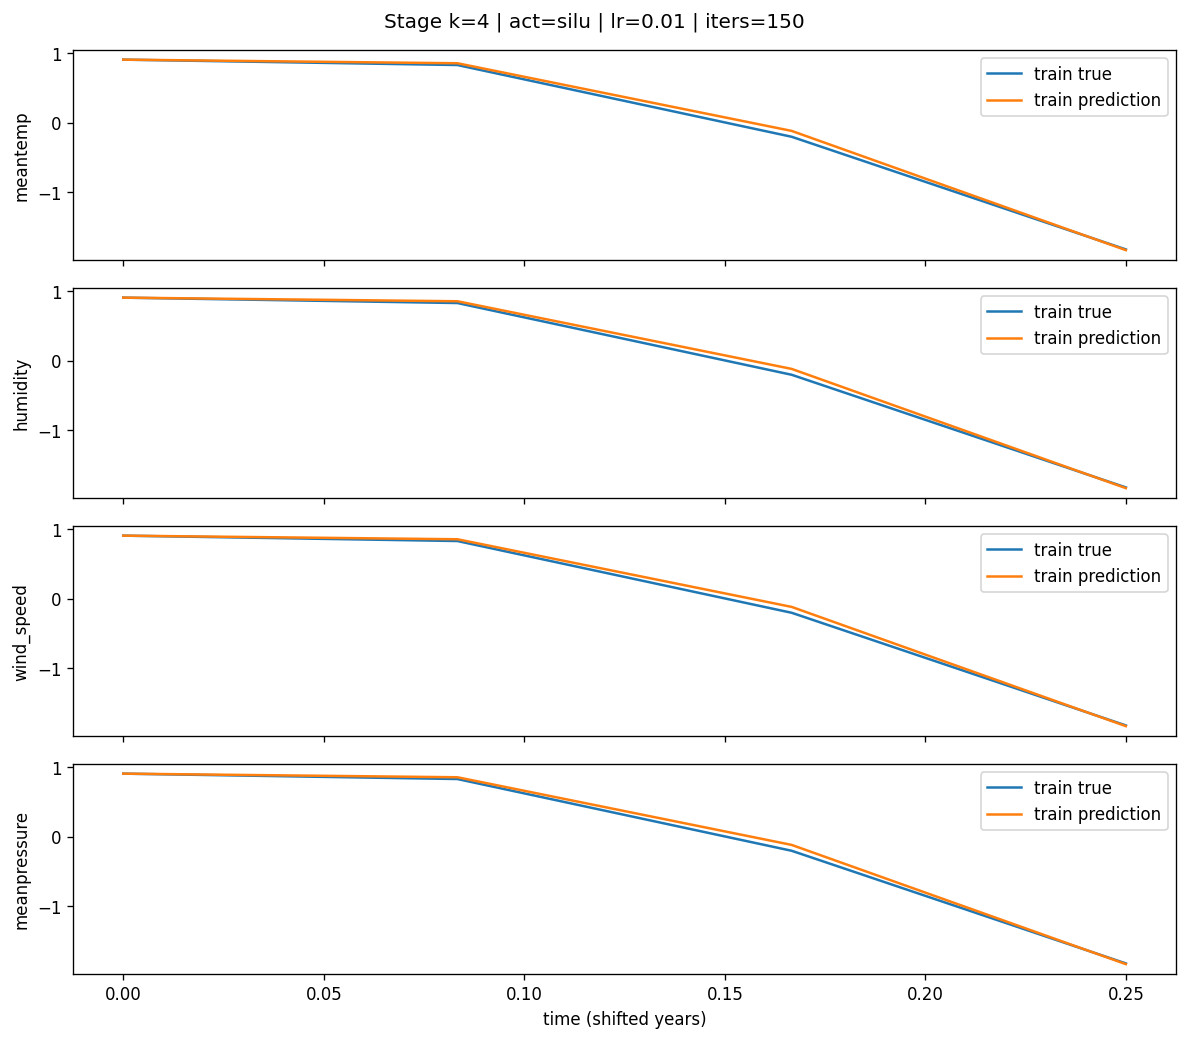

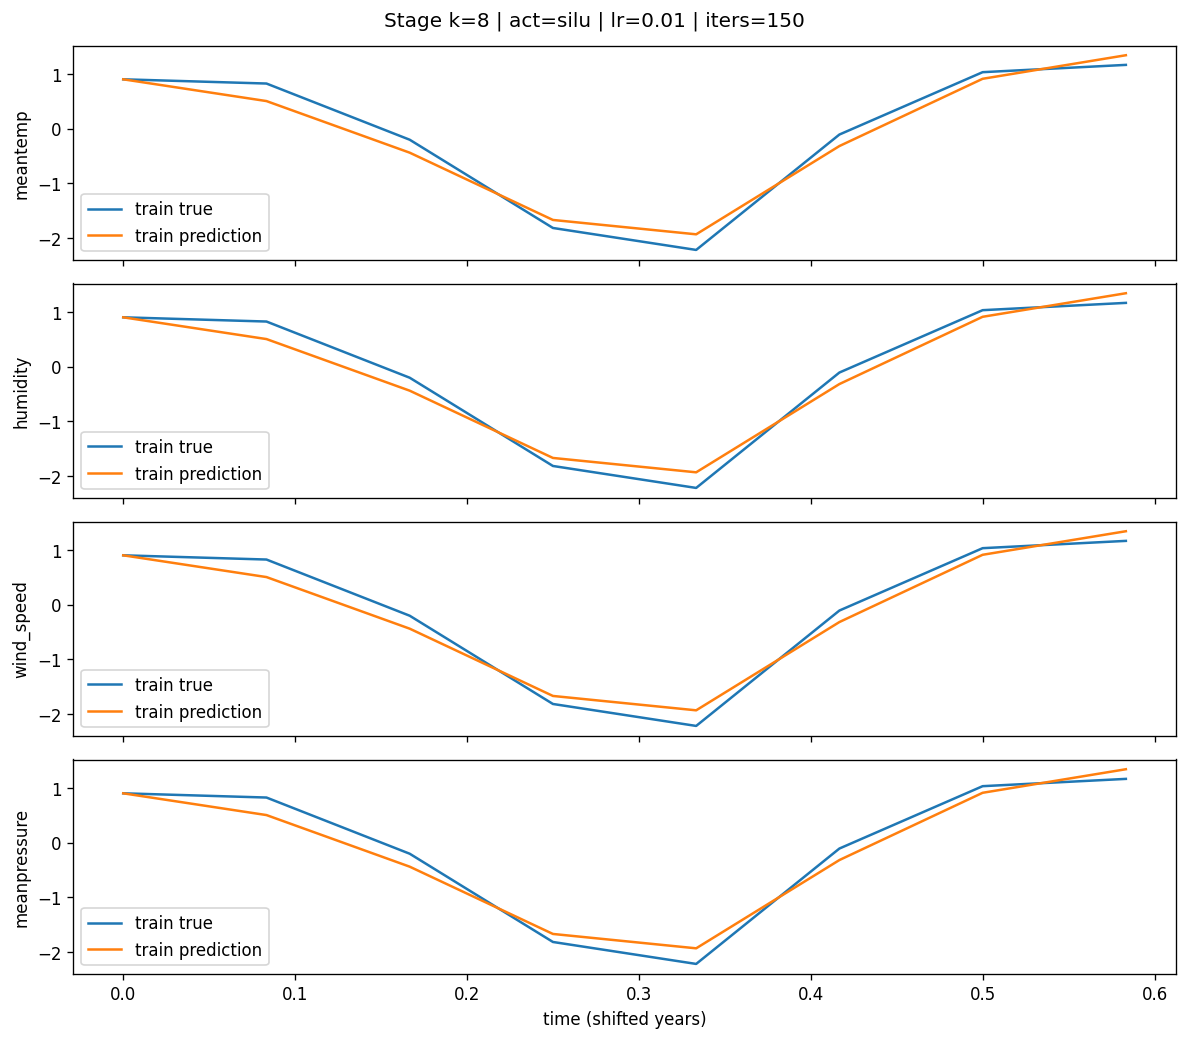

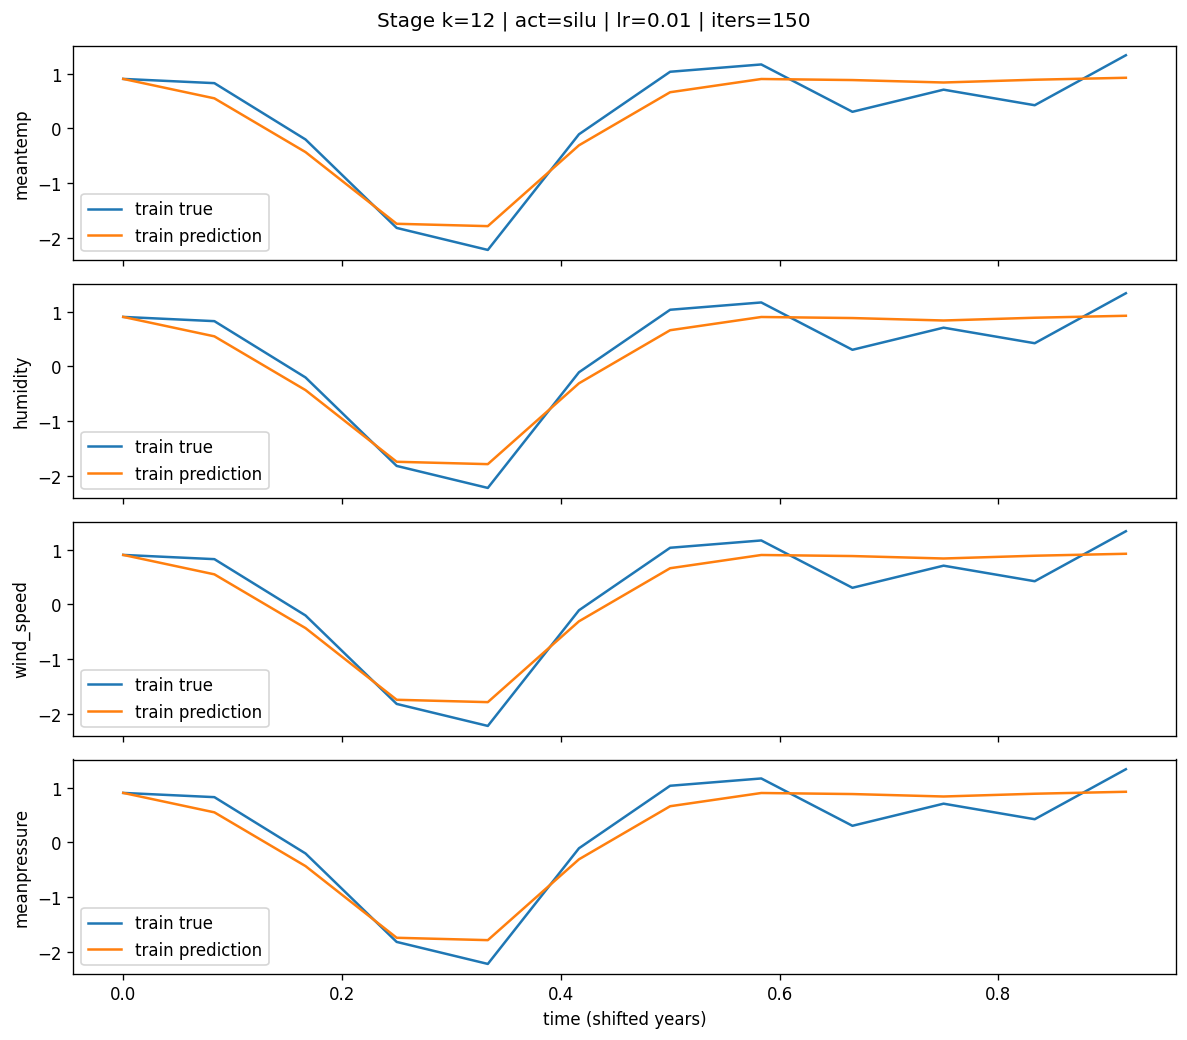

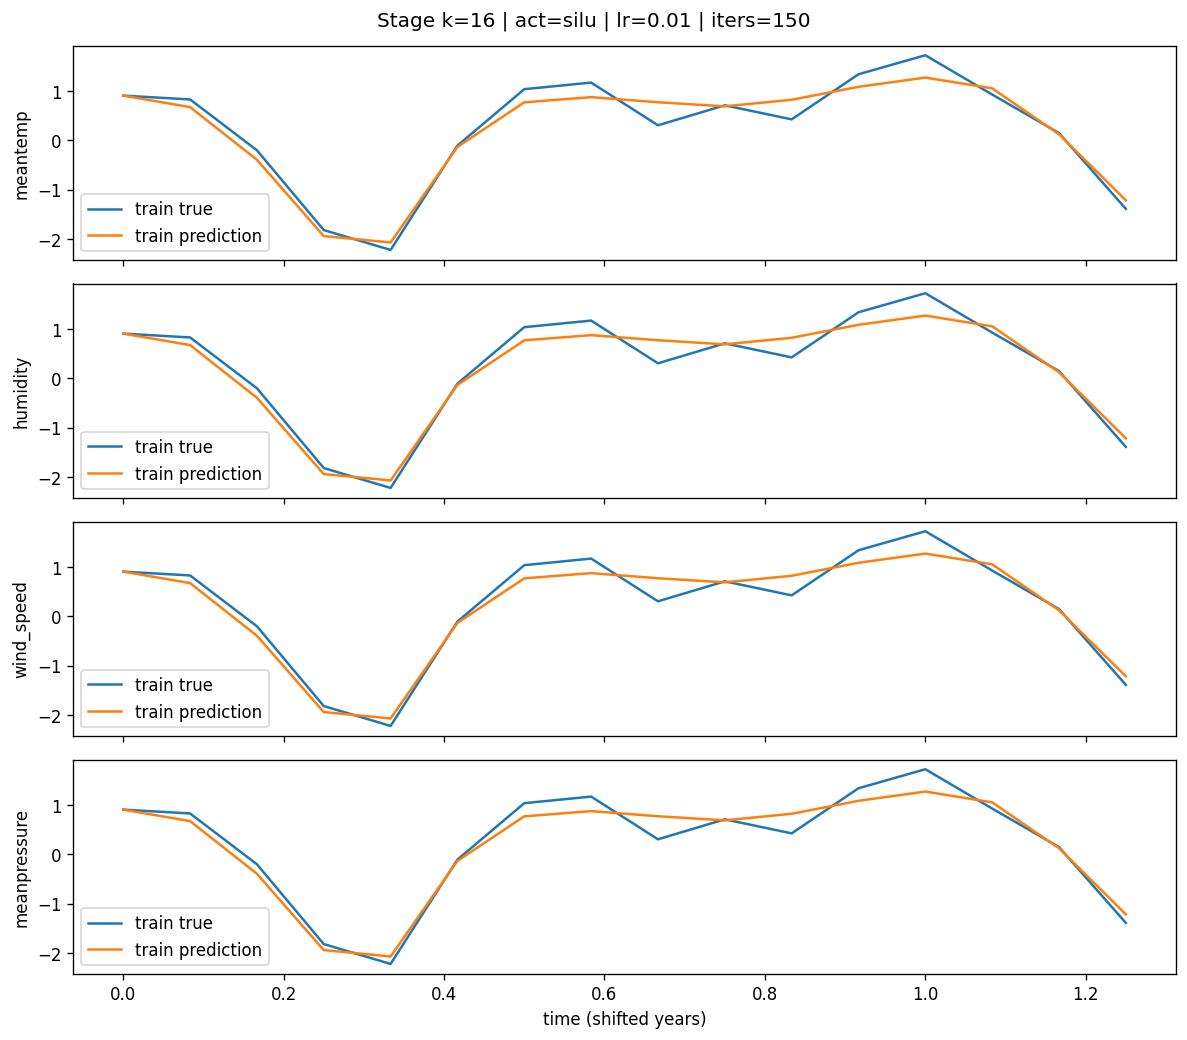

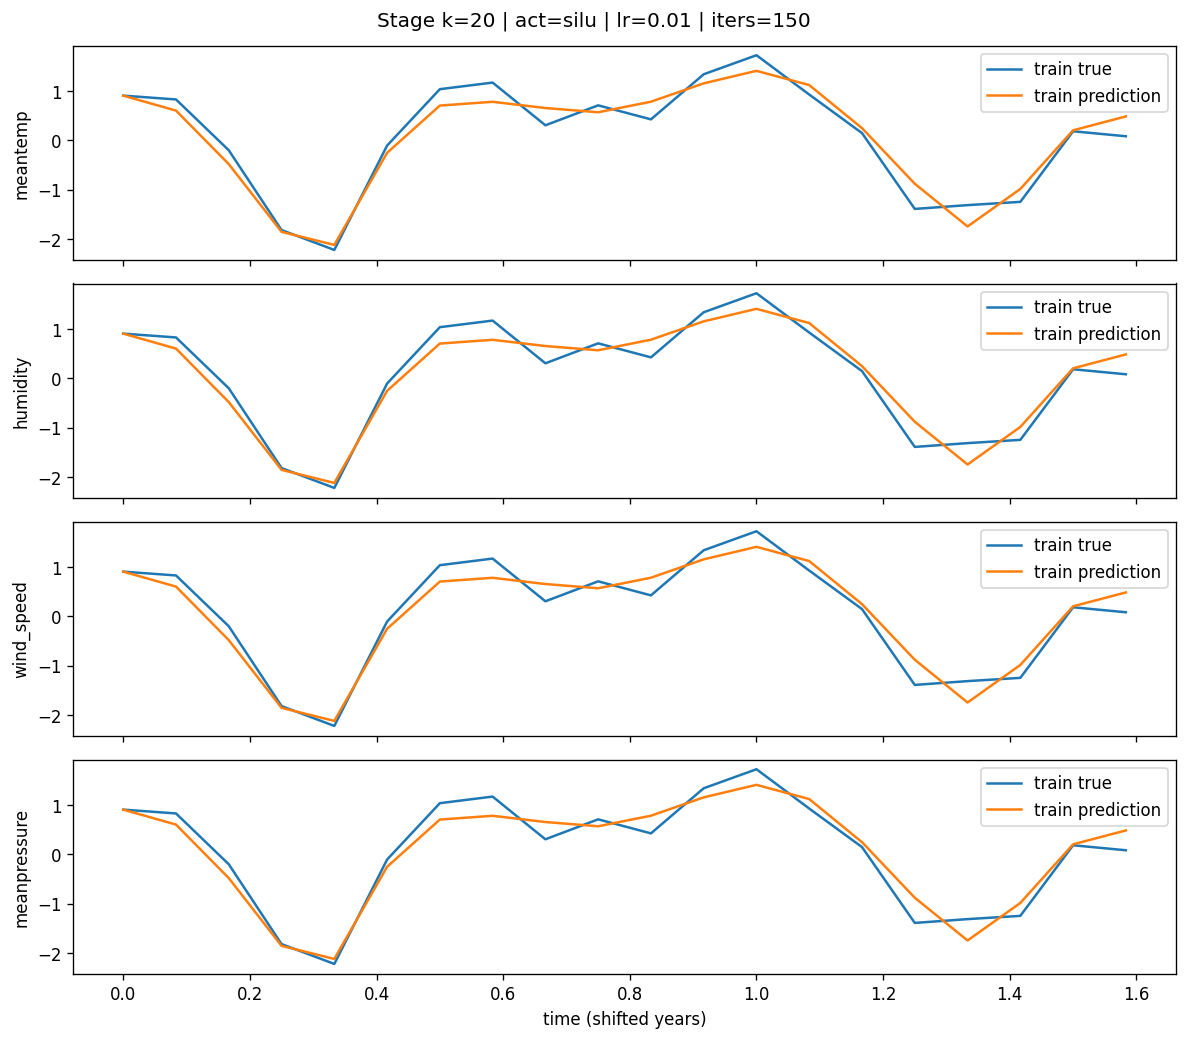

[(16, 80, 0.05595911666750908),
 (16, 160, 0.048401497304439545),
 (16, 240, 0.04301615059375763),
 (16, 320, 0.054333314299583435),
 (16, 400, 0.036433134227991104),
 (20, 80, 0.04678451269865036),
 (20, 160, 0.05487382039427757),
 (20, 240, 0.039330363273620605),
 (20, 320, 0.038030918687582016),
 (20, 400, 0.035227227956056595)]

In [17]:
func2, hist2 = train_incremental(
    act="silu",
    lr=1e-2,
    iters_per_stage=150,
    stage_step=4,
    method="dopri5",
    rtol=1e-6,
    atol=1e-6,
)

hist[-10:]

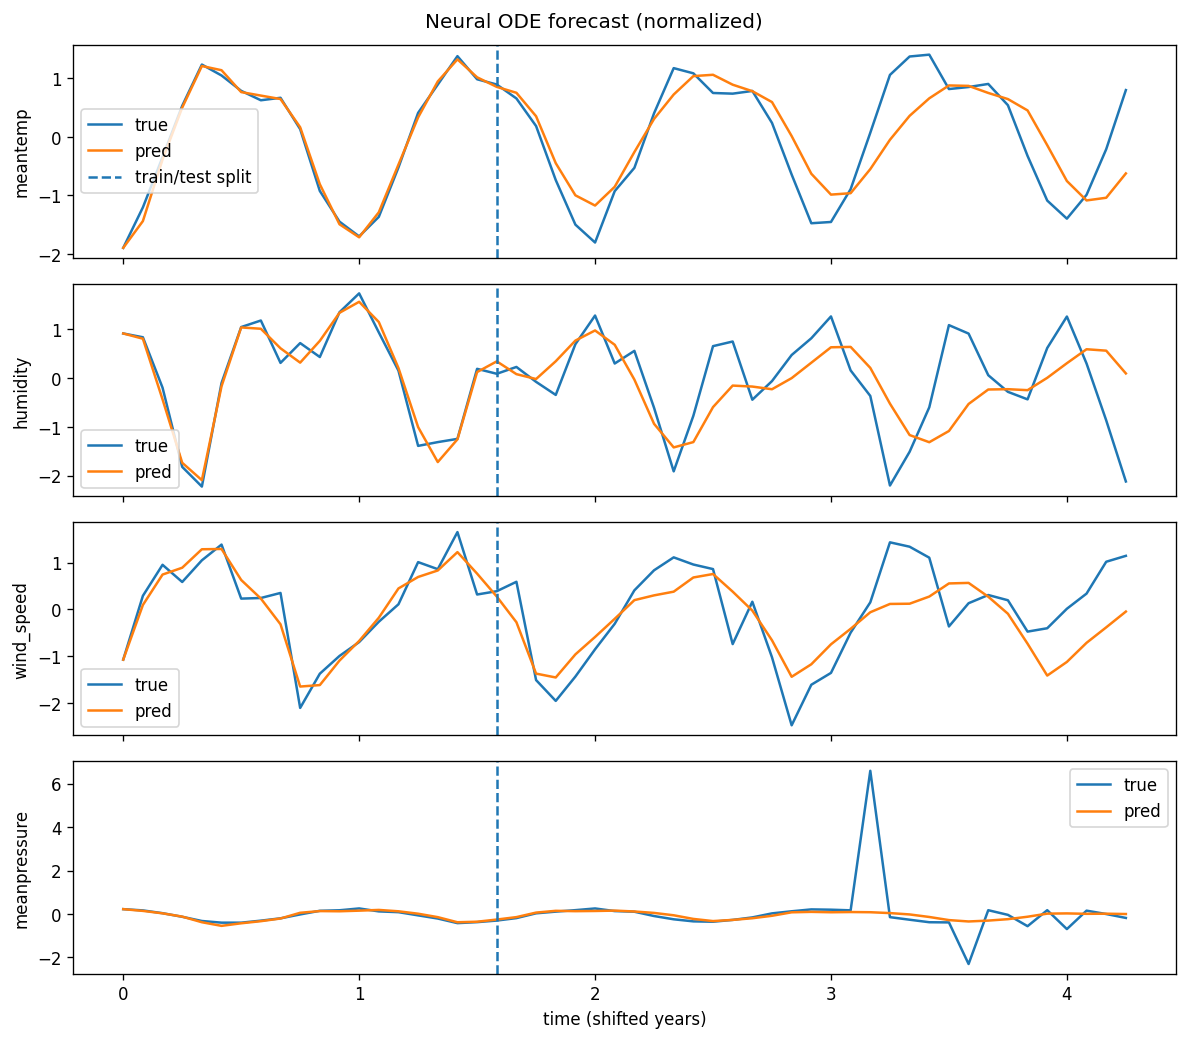

In [11]:
with torch.no_grad():
    y0_full = y_train[0]
    pred_full = rollout(func, y0_full, t_torch, rtol=1e-6, atol=1e-6, method="dopri5")
    pred_full = pred_full.detach().cpu().numpy()
    true_full = Y_torch.detach().cpu().numpy()
    t_full = t_torch.detach().cpu().numpy()

split_time = t_full[T_train-1]

fig, axes = plt.subplots(true_full.shape[1], 1, figsize=(10, 2.2*true_full.shape[1]), sharex=True)
if true_full.shape[1] == 1: axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(t_full, true_full[:, i], label="true")
    ax.plot(t_full, pred_full[:, i], label="pred")
    ax.axvline(split_time, linestyle="--", label="train/test split" if i == 0 else None)
    ax.set_ylabel(features[i])
    ax.legend()

axes[-1].set_xlabel("time (shifted years)")
fig.suptitle("Neural ODE forecast (normalized)")
plt.tight_layout()
plt.show()

In [12]:
#unnormalize the data. plot the units temp in C humidity in g/m3 of water, wind in km/h and pressure in hPa

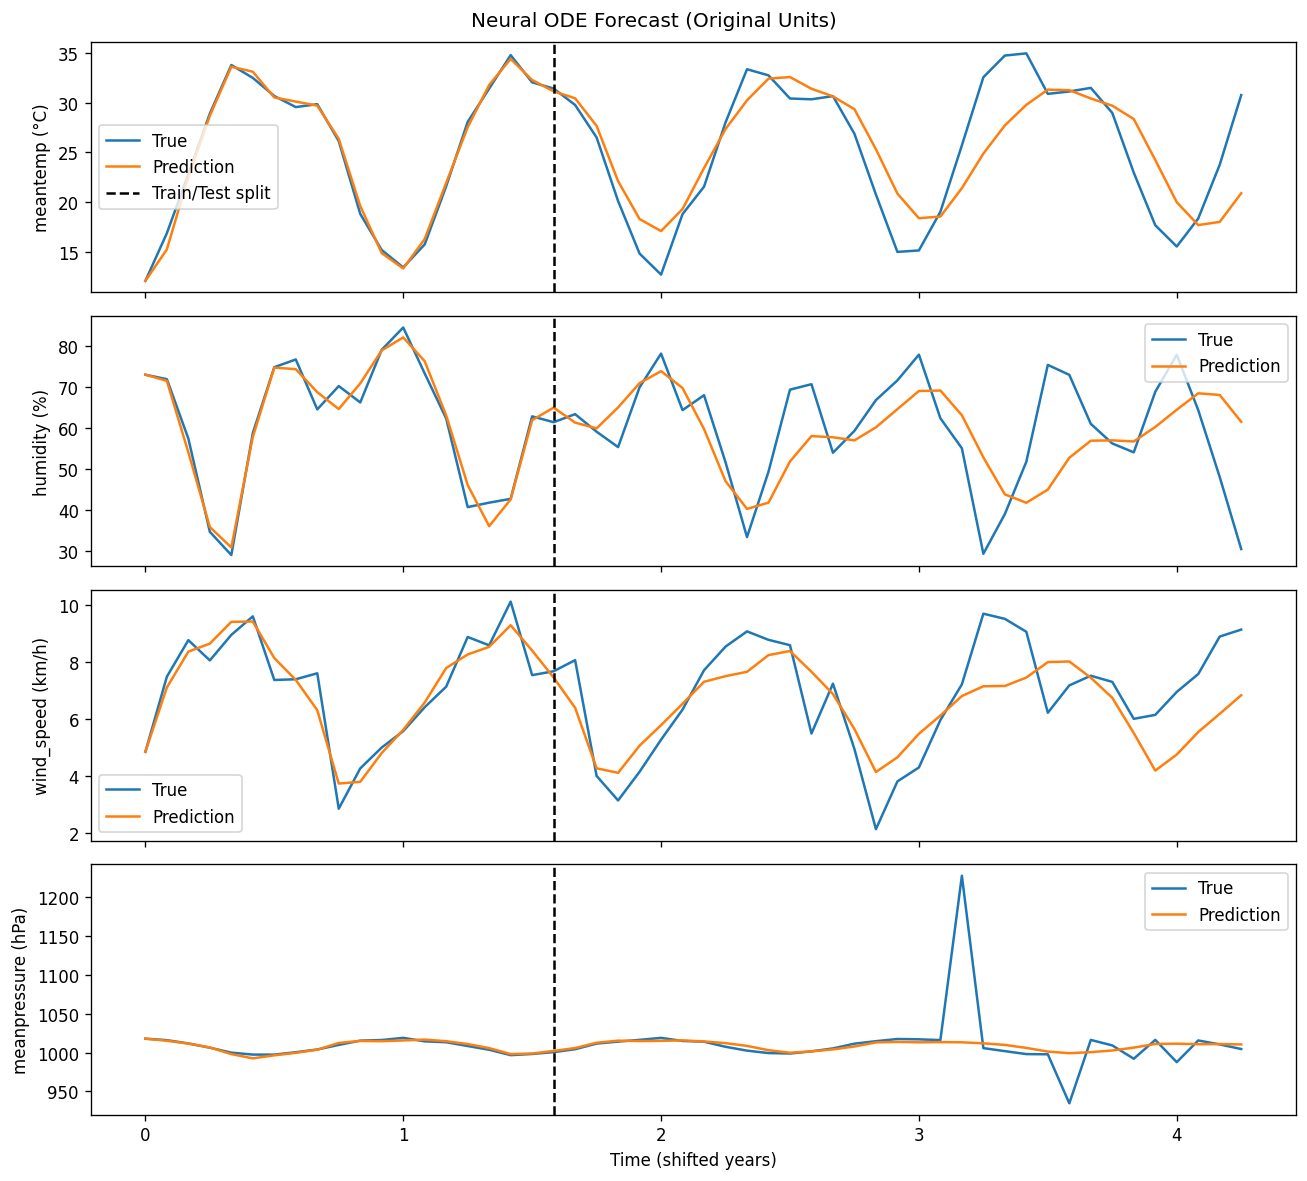

In [13]:
# Convert normalized predictions back to original scale
with torch.no_grad():
    y0_full = y_train[0]
    pred_full_norm = rollout(func, y0_full, t_torch, rtol=1e-6, atol=1e-6)
    pred_full_norm = pred_full_norm.cpu().numpy()

true_full_norm = Y_torch.cpu().numpy()
t_full = t_torch.cpu().numpy()

# Unnormalize
pred_full = pred_full_norm * Y_std + Y_mean
true_full = true_full_norm * Y_std + Y_mean

# Units for labeling
units = {
    "meantemp": "°C",
    "humidity": "%",
    "wind_speed": "km/h",
    "meanpressure": "hPa"  # dataset likely mislabeled as atm; realistically hPa
}

split_time = t_full[T_train-1]

fig, axes = plt.subplots(len(features), 1, figsize=(11, 2.5*len(features)), sharex=True)

if len(features) == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(t_full, true_full[:, i], label="True")
    ax.plot(t_full, pred_full[:, i], label="Prediction")
    ax.axvline(split_time, linestyle="--", color="black", label="Train/Test split" if i == 0 else None)

    ax.set_ylabel(f"{features[i]} ({units[features[i]]})")
    ax.legend()

axes[-1].set_xlabel("Time (shifted years)")
fig.suptitle("Neural ODE Forecast (Original Units)")
plt.tight_layout()
plt.show()


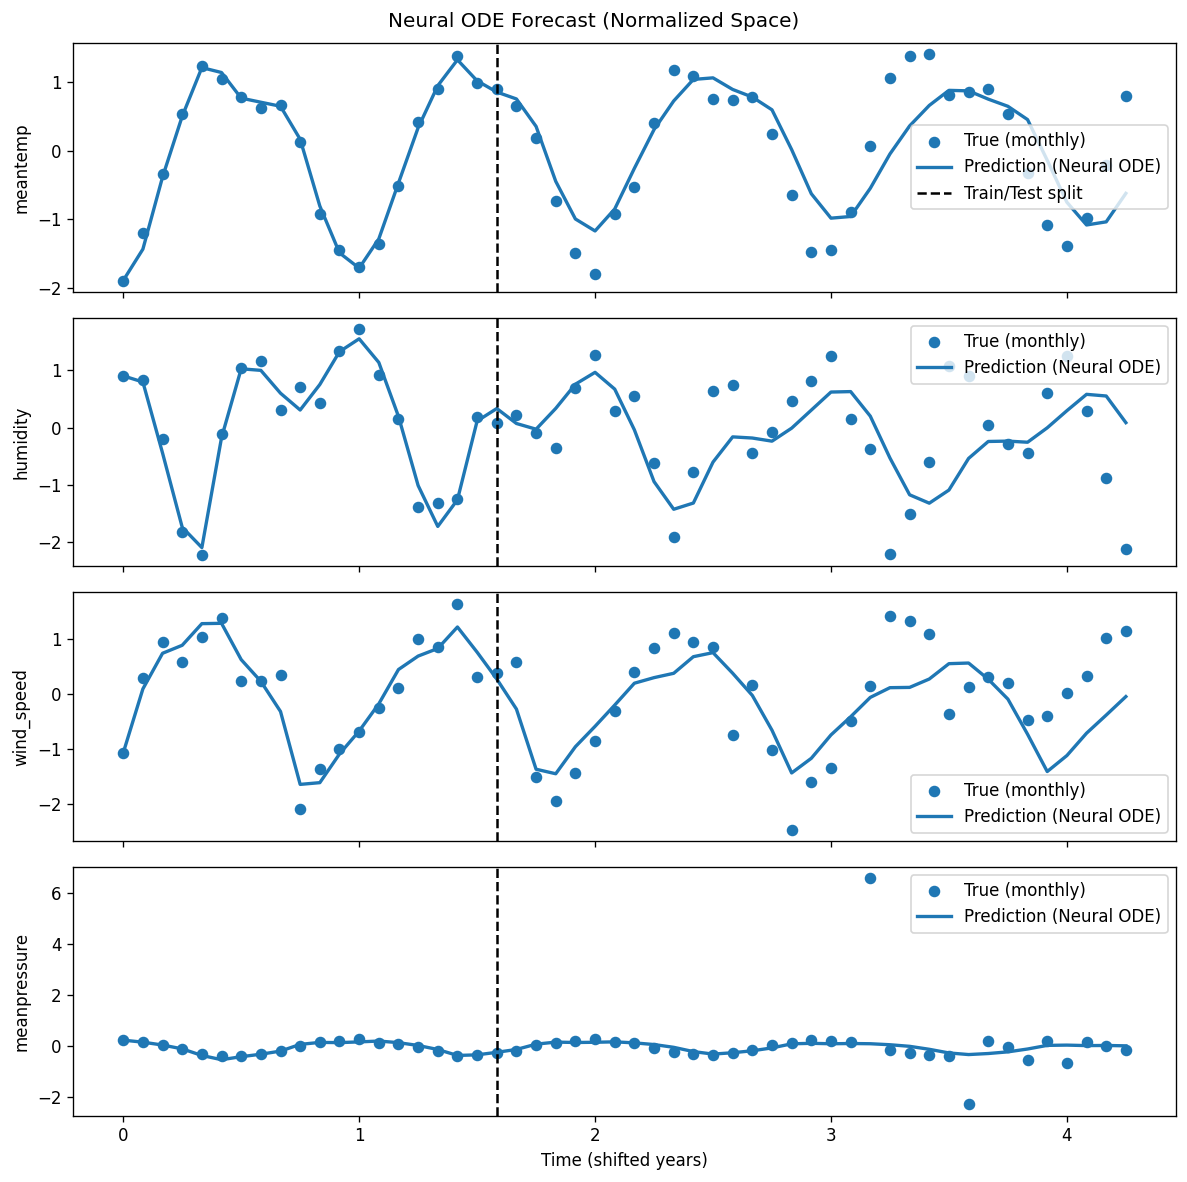

In [16]:
with torch.no_grad():
    y0_full = y_train[0]
    pred_full = rollout(func, y0_full, t_torch, rtol=1e-6, atol=1e-6)
    pred_full = pred_full.cpu().numpy()

true_full = Y_torch.cpu().numpy()
t_full = t_torch.cpu().numpy()

split_time = t_full[T_train-1]

fig, axes = plt.subplots(true_full.shape[1], 1, figsize=(10, 2.5*true_full.shape[1]), sharex=True)

if true_full.shape[1] == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # True measurements as points
    ax.scatter(t_full, true_full[:, i], label="True (monthly)", s=35)

    # Prediction as continuous line
    ax.plot(t_full, pred_full[:, i], label="Prediction (Neural ODE)", linewidth=2)

    # Train/test split
    ax.axvline(split_time, linestyle="--", color="black",
               label="Train/Test split" if i == 0 else None)

    ax.set_ylabel(features[i])
    ax.legend()

axes[-1].set_xlabel("Time (shifted years)")
fig.suptitle("Neural ODE Forecast (Normalized Space)")
plt.tight_layout()
plt.show()

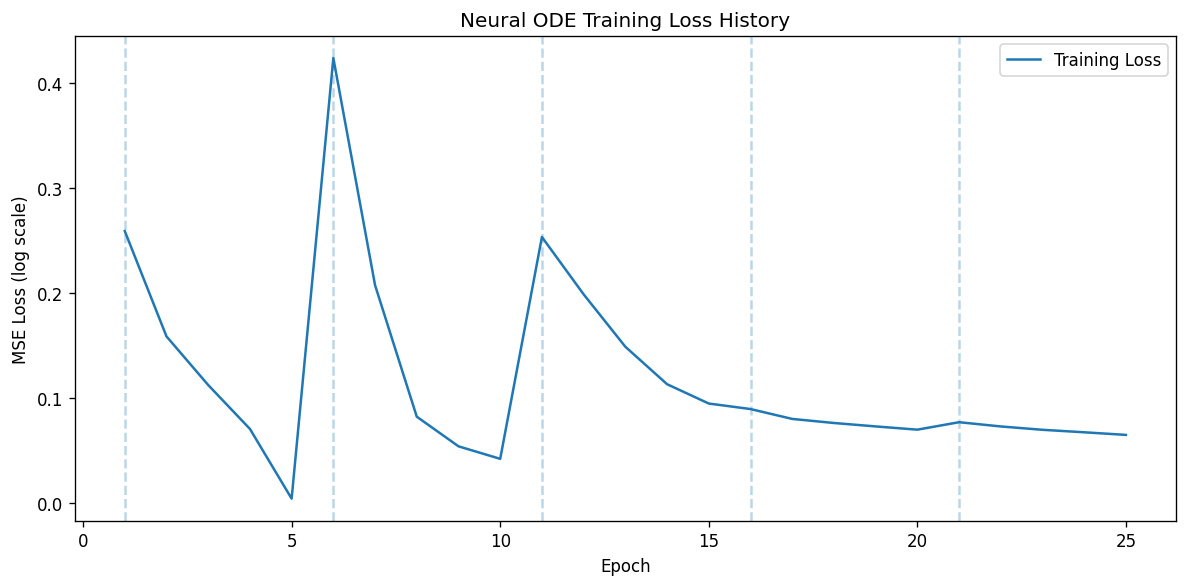

In [37]:
# Convert history to DataFrame
hist_df = pd.DataFrame(hist2, columns=["stage_k", "iter_in_stage", "loss"])

# Create a global epoch index
hist_df["global_epoch"] = range(1, len(hist_df) +1)

# Identify stage transition points
stage_changes = hist_df.groupby("stage_k")["global_epoch"].min().values

# Plot
plt.figure(figsize=(10, 5))

plt.plot(hist_df["global_epoch"], hist_df["loss"], label="Training Loss")


# Mark stage boundaries
for sc in stage_changes:
    plt.axvline(sc, linestyle="--", alpha=0.3)

plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.title("Neural ODE Training Loss History")
plt.legend()
plt.tight_layout()
plt.show()

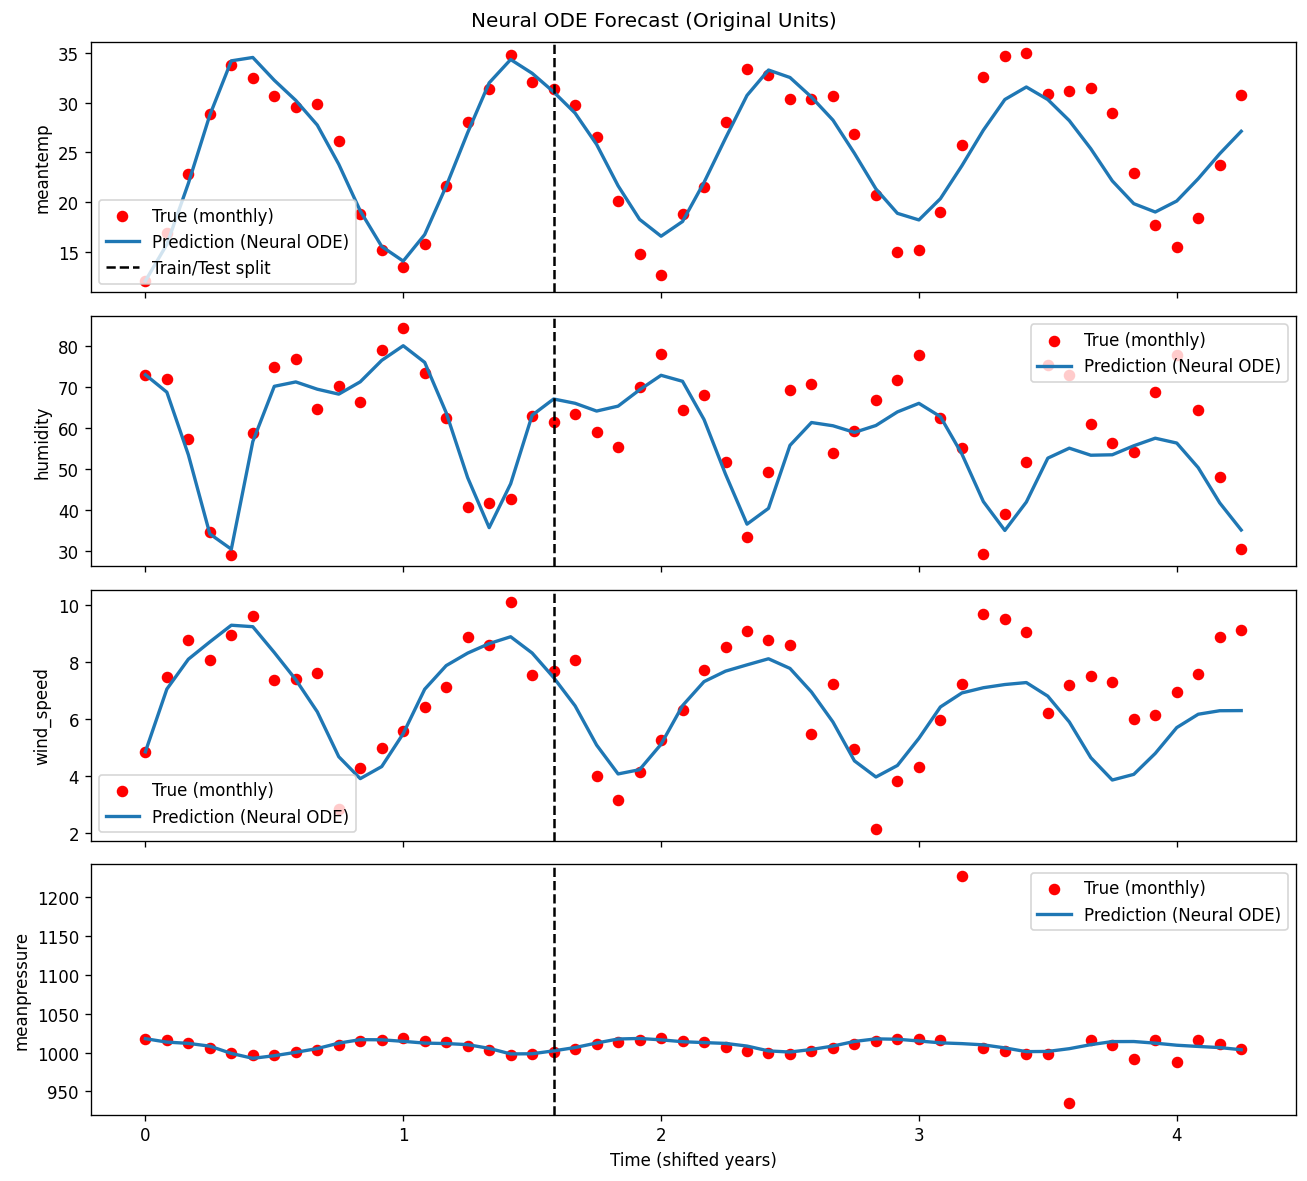

In [21]:
# Convert normalized predictions back to original scale
with torch.no_grad():
    y0_full = y_train[0]
    pred_full_norm = rollout(func2, y0_full, t_torch, rtol=1e-6, atol=1e-6)
    pred_full_norm = pred_full_norm.cpu().numpy()

true_full_norm = Y_torch.cpu().numpy()
t_full = t_torch.cpu().numpy()

# Unnormalize
pred_full = pred_full_norm * Y_std + Y_mean
true_full = true_full_norm * Y_std + Y_mean

# Units for labeling
units = {
    "meantemp": "°C",
    "humidity": "%",
    "wind_speed": "km/h",
    "meanpressure": "hPa"  # dataset likely mislabeled as atm; realistically hPa
}

split_time = t_full[T_train-1]

fig, axes = plt.subplots(len(features), 1, figsize=(11, 2.5*len(features)), sharex=True)

if len(features) == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # True measurements as points
    ax.scatter(t_full, true_full[:, i], label="True (monthly)", s=35, color='red')

    # Prediction as continuous line
    ax.plot(t_full, pred_full[:, i], label="Prediction (Neural ODE)", linewidth=2)

    # Train/test split
    ax.axvline(split_time, linestyle="--", color="black",
               label="Train/Test split" if i == 0 else None)

    ax.set_ylabel(features[i])
    ax.legend()


axes[-1].set_xlabel("Time (shifted years)")
fig.suptitle("Neural ODE Forecast (Original Units)")
plt.tight_layout()
plt.show()